In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

import warnings
warnings.simplefilter("ignore")

In [3]:
featureNames = ["seq", "mcg", "gvh", "alm", "mit", "erl", "pox", "vac", "nuc", "loc"]
yeastData = pd.read_csv("yeast.data", sep=" ", names=featureNames)
kFold = KFold(n_splits=2, shuffle=False, random_state=39)
yeastAttrib = yeastData.iloc[:,1:9].values  # fix column indexes
yeastTarget = yeastData["loc"].values

titles = ("GradientBoost", "KNN", "Gaussian", "Random Forest") # add more
models = (GradientBoostingClassifier(n_estimators=100, max_features=None, max_depth=2, random_state=5),
            KNeighborsClassifier(),
            GaussianNB(),
            RandomForestClassifier())

------------Fold 1
GradientBoost
             precision    recall  f1-score   support

        CYT       0.45      0.61      0.52       198
        ERL       0.00      0.00      0.00         5
        EXC       0.43      0.32      0.36        19
        ME1       0.52      0.65      0.58        17
        ME2       0.48      0.39      0.43        33
        ME3       0.72      0.89      0.80        74
        MIT       0.82      0.42      0.55       180
        NUC       0.50      0.53      0.52       197
        POX       0.55      0.43      0.48        14
        VAC       0.00      0.00      0.00         5

avg / total       0.58      0.54      0.54       742

Confusion Matrix: 
 [[121   0   0   0   1   6   7  62   0   1]
 [  0   0   2   0   2   0   0   0   0   1]
 [  5   0   6   3   3   0   0   1   0   1]
 [  0   0   2  11   2   1   0   0   1   0]
 [  2   0   2   5  13   3   1   3   2   2]
 [  0   0   0   0   0  66   0   8   0   0]
 [ 61   0   2   2   2   8  75  27   2   1]
 [ 74  

Confusion Matrix: 
 [[136   1   1   0   1  56  70   0   0]
 [  1  10   2   1   0   2   0   0   0]
 [  0   6  11  10   0   0   0   0   0]
 [  4   3   2   4   2   1   2   0   0]
 [  9   1   3   3  60   4   9   0   0]
 [ 19   0   0   0   1  35   9   0   0]
 [ 84   0   0   0   9  25 114   0   0]
 [  1   1   0   1   1   1   1   0   0]
 [ 12   2   1   1   5   4   0   0   0]]
[8/8] features ████████████████████ Time elapsed: 0 seconds



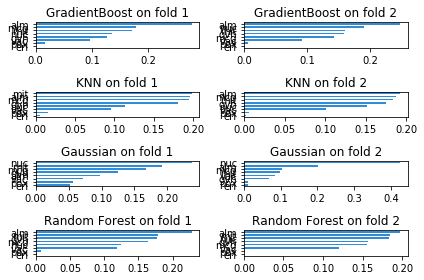

In [17]:
fold = 1
fig, axs = plt.subplots(len(models), kFold.n_splits)
for train_index, test_index in kFold.split(yeastAttrib):
    print(f"------------"
          f"Fold {fold}")
    modelno = 1
    for model, title in zip(models, titles):
        train_data, train_target = yeastAttrib[train_index], yeastTarget[train_index]
        test_data, test_target = yeastAttrib[test_index], yeastTarget[test_index]
        clf = model.fit(train_data, train_target)

        prediction = clf.predict(test_data)
        print(f"{title}")
        print(classification_report(test_target, prediction))
        print(f"Confusion Matrix: \n {confusion_matrix(test_target, prediction)}")

        ax = axs[modelno - 1, fold - 1]
        interpreter = Interpretation(test_data, feature_names=featureNames[1:9])
        model_no_proba = InMemoryModel(model.predict, examples=test_data, unique_values=model.classes_)
        interpreter.feature_importance.plot_feature_importance(model_no_proba, ascending=False, ax=ax)
        ax.set_title(f"{title} on fold {fold}")
        print("\n")
        modelno += 1
    fold += 1
plt.tight_layout()

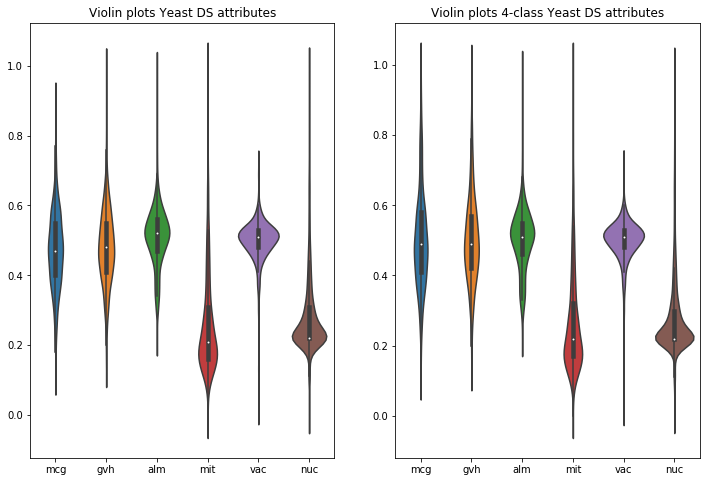

In [14]:
yeast4Classes = yeastData.loc[(yeastData["loc"] == "CYT")|( yeastData["loc"] == "NUC" )| (yeastData["loc"] == "MIT" )| (yeastData["loc"] == "ME3")]
yeastAttrib = yeast4Classes.iloc[:, 1:9].values  # fix column indexes
yeastTarget = yeast4Classes["loc"].values
plt.rcParams["figure.figsize"] = (15,8)
plt.subplot(1,2,1)
plt.title("Violin plots Yeast DS attributes")
ax = sns.violinplot(data=yeast4Classes.iloc[:, [1, 2, 3, 4, 7, 8]], orient="v")
plt.subplot(1, 2, 2)
plt.title("Violin plots 4-class Yeast DS attributes")
ax = sns.violinplot(data=yeastData.iloc[:, [1, 2, 3, 4, 7, 8]], orient="v")

In [ ]:
fold = 1
fig, axs = plt.subplots(len(models), kFold.n_splits)
for train_index, test_index in kFold.split(yeastAttrib):
    print(f"------------"
          f"Fold {fold}")
    modelno = 1
    for model, title in zip(models, titles):
        train_data, train_target = yeastAttrib[train_index], yeastTarget[train_index]
        test_data, test_target = yeastAttrib[test_index], yeastTarget[test_index]
        clf = model.fit(train_data, train_target)

        prediction = clf.predict(test_data)
        print(f"{title}")
        print(classification_report(test_target, prediction))
        print(f"Confusion Matrix: \n {confusion_matrix(test_target, prediction)}")

        ax = axs[modelno - 1, fold - 1]
        interpreter = Interpretation(test_data, feature_names=featureNames[1:9])
        model_no_proba = InMemoryModel(model.predict, examples=test_data, unique_values=model.classes_)
        interpreter.feature_importance.plot_feature_importance(model_no_proba, ascending=False, ax=ax)
        ax.set_title(f"{title} on fold {fold}")
        print("\n")
        modelno += 1
    fold += 1
plt.tight_layout()

In [ ]:
# Add PDPs
# Add ICE

In [ ]:
# Add surrogate (¿our own or Skater's?)